# EBA3500 Lecture 8. Omnibus tests.

We'll use the `titanic` data set once again. 

In [142]:
!pip install pyreadr
import pyreadr, os, pathlib

def pyreadr_load(url, local_file = "temp_pyreadr.rda"):
  """Download the R dataset at the specified url into local_file, load the 
  local file, delete the local file. Return the dataset."""
  
  file_name = pyreadr.download_file(url, local_file)
  dataframe = pyreadr.read_r(file_name)
  os.remove(str(pathlib.Path().resolve()) + "/" + file_name)
  name = next(iter(dataframe.items()))[0]
  return dataframe[name]

In [143]:
url = 'https://github.com/kassambara/datarium/blob/master/data/titanic.raw.rda?raw=true'
titanic = pyreadr_load(url)
titanic.head()

,Class,Sex,Age,Survived
0,3rd,Male,Child,No
1,3rd,Male,Child,No
2,3rd,Male,Child,No
3,3rd,Male,Child,No
4,3rd,Male,Child,No


## The omnibus test

Omnibus sounds scary, but is latin for "all". It also an archaic way of saying "bus".

Recall the Titanic data. How can we test if there is a real difference in survival between the sexes? Easy, we run a *t*-test. Equivalently, we run a linear regression and look at the *p*-value of one of the category not in the baseline.

In [144]:
titanic["Survived_01"] = 1 * (titanic.Survived == "Yes")

In [145]:
x = titanic[titanic["Sex"] == "Female"]
x

,Class,Sex,Age,Survived,Survived_01
35,3rd,Female,Child,No,0
36,3rd,Female,Child,No,0
37,3rd,Female,Child,No,0
38,3rd,Female,Child,No,0
39,3rd,Female,Child,No,0
...,...,...,...,...,...
2196,Crew,Female,Adult,Yes,1
2197,Crew,Female,Adult,Yes,1
2198,Crew,Female,Adult,Yes,1
2199,Crew,Female,Adult,Yes,1


In [146]:
y = titanic[titanic["Sex"] == "Male"]
y

,Class,Sex,Age,Survived,Survived_01
0,3rd,Male,Child,No,0
1,3rd,Male,Child,No,0
2,3rd,Male,Child,No,0
3,3rd,Male,Child,No,0
4,3rd,Male,Child,No,0
...,...,...,...,...,...
1880,Crew,Male,Adult,Yes,1
1881,Crew,Male,Adult,Yes,1
1882,Crew,Male,Adult,Yes,1
1883,Crew,Male,Adult,Yes,1


In [147]:
import statsmodels.api as sm
sm.stats.ttest_ind(x.Survived_01, y.Survived_01)

(24.000594650874334, 2.98891210006274e-113, 2199.0)

The first value is the *t*-value, the second is the *p*-value. Definitely a difference between the sexes here, which we already knew from looking at the plots.

In [149]:
import numpy as np
np.mean(x["Survived_01"]) # female survivale
np.mean(y["Survived_01"]) # male survival

0.2120161756210283

In this case though, it's easier just to run a regression.

In [153]:
import statsmodels.formula.api as smf
fit = smf.ols("Survived_01 ~ Sex", data = titanic).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Survived_01   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     576.0
Date:                Thu, 14 Oct 2021   Prob (F-statistic):          2.99e-113
Time:                        10:12:10   Log-Likelihood:                -1194.1
No. Observations:                2201   AIC:                             2392.
Df Residuals:                    2199   BIC:                             2404.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7319      0.019     38.100      0.000       0.694       0.770
Sex[T.Male]    -0.5199      0.022    -24.001      0.000      -0.562      -0.477
==============================================================================
Omnibus:                      184.584   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.425
Skew:                           0.780   Prob(JB):                     2.50e-50
Kurtosis:                       2.756   Cond. No.                         4.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
fit.pvalues

Intercept      2.433710e-244
Sex[T.Male]    2.988912e-113
dtype: float64

The *p*-value of `Sex[T.Male]` matches the *p*-value of the *t*-test above.

But what can we do when we have more than $2$ categories? For $k$ categories, there is more than one *p*-value to look at!

In [154]:
fit = smf.ols("Survived_01 ~ Class", data = titanic).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Survived_01   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     69.35
Date:                Thu, 14 Oct 2021   Prob (F-statistic):           7.56e-43
Time:                        10:14:12   Log-Likelihood:                -1350.6
No. Observations:                2201   AIC:                             2709.
Df Residuals:                    2197   BIC:                             2732.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6246      0.025     25.171      0.000       0.576       0.673
Class[T.2nd]     -0.2106      0.036     -5.800      0.000      -0.282      -0.139
Class[T.3rd]     -0.3725      0.030    -12.422      0.000      -0.431      -0.314
Class[T.Crew]    -0.3851      0.029    -13.271      0.000      -0.442      -0.328
==============================================================================
Omnibus:                      758.455   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              292.650
Skew:                           0.727   Prob(JB):                     2.83e-64
Kurtosis:                       1.962   Cond. No.                         6.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can, using this regression output, answer probabilistic questions such as "is the coefficient $\beta_{\textrm{2nd}} = 0$?". But we can't answer the omnibus question "Is at least one of the $\beta$s (except the intercept $\beta_0$), not equal to 0?"
This question is about the usesfulness of all the entire categorical variable, not just its isolated $\beta$ coefficients.


### Look at sum of squares
Recall the definition of the $R^2$ for multiple regression models,
$$
R^2 = 1-\frac{\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{k=1}^{K}\beta_{k}x_{k}\right)^{2}}{\sum_{i=1}^{n}(y_{i}-\overline{y})^{2}}.
$$

The $R^2$ quantifies the relative reduction in the sum of squares attained by using the covariates $x_1, x_2, ..., x_k$.

Suppose we have one categorial covariate $X$ taking on values in $a_1, a_2, ..., a_K$, and we deal with the model $y = \beta_{0}+\sum_{k=2}^{K}\beta_{k}1[X=a_{k}]$. (Here the regression coefficeint for $a_1$ has been absorbed into the baseline.)

Then the $R^2$ equals
$$
1-\frac{\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{k=1}^{K}\beta_{k}1[X=a_{k}]\right)^{2}}{\sum_{i=1}^{n}(y_{i}-\overline{y})^{2}}.
$$
This $R^2$ quantifies the reduction in sum of squares obtained by including *all* the $\beta$s associated with the categorical variable $X$ in the regression model.

Thus, instead of testing whether there is a parameter that is not equal to $0$, we will test if the $R^2$ is equal to $0$.
Consider the following testing problem
$$
H_{0}:R^{2}=0,\quad H_{a}:R^{2}>0
$$
This is equivalent to
$$
H_{0}:\beta_{2}=\beta_{3}=...=\beta_{K}=0, \quad H_{a}:\beta_{i}\neq 0\textrm{ for some }i
$$
To see why, notice that $R^2 = 0$ if and only if all the $\beta_i$s, $i\geq2$,are equal to $0$. 

### Testing $R^2 = 0$
For the tests we are going to discuss to be formally correct, we will have to assume that the regression
model 
$$y = \beta_{0}+\sum_{k=2}^{K}\beta_{k}1[X=a_{k}] + \epsilon$$
is true, where the residuals $\epsilon$ are independent and normal with zero mean and the same variance. The assumptions about are not critical though, and the tests works well when the residuals aren't normally distributed.

Under these conditions, we find that, when $\beta_i = 0$ for all $i > 1$, 
$$
R^2 \sim \textrm{Beta}\left(\frac{K-1}{2},\frac{n-K}{2}\right),
$$
where $\textrm{Beta}(a,b)$ denotes the Beta distribution with parameters $a,b$. Moreover, "$\sim$" means "distributed as". 

### What does this mean?


In terms of simulation, it means that the simulated $R^2$ will have a histogram that approximates the density of a $\textrm{Beta}\left(\frac{K-1}{2},\frac{n-K}{2}\right)$-distributed variable arbitrarily well when the number of simulations go to infinity. 

The simulated values have to be from the null-hypothesis, i.e., they must be normally distributed with some mean $\mu$ and standard deviation $\sigma$.

In [155]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(seed = 313)
n_reps = 10 ** 4

n = 20
K = K
y = rng.normal(0, 1, (n_reps, n))
y

array([[-0.10476825,  1.200623  , -0.38544127, ..., -0.36334591,
        -0.79925663, -0.85709784],
       [ 1.57469391, -1.13584913,  2.15868501, ..., -1.00557318,
        -0.66484784, -0.31447754],
       [ 0.90012285,  1.01632256, -0.20860774, ...,  2.05125315,
        -0.61617816,  1.88551235],
       ...,
       [-0.49747136, -0.56413613,  0.08626853, ...,  0.92477878,
        -1.02178499, -0.52129338],
       [ 0.43491177,  0.43304638, -1.3601706 , ..., -0.60534607,
         0.60160771, -0.39902685],
       [-0.44078295, -0.07041964,  1.55085301, ...,  1.03522783,
         0.67758851,  0.86163172]])

Let's simulate some $R^2$s from a subset of the Titanic data.

In [156]:
import statsmodels.formula.api as smf
titanic_2 = titanic.sample(n)

def func1d(y):
  titanic_2.y = y
  fit = smf.ols("y ~ Class", data = titanic_2).fit()
  return fit.rsquared

rsqs = np.apply_along_axis(
    func1d = func1d,
    axis = 1,
    arr = y
)

rsqs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


array([0.06004274, 0.11528575, 0.01384137, ..., 0.10826497, 0.04976875,
       0.03199749])

In [159]:
K = len(set(titanic_2.Class))
K

3

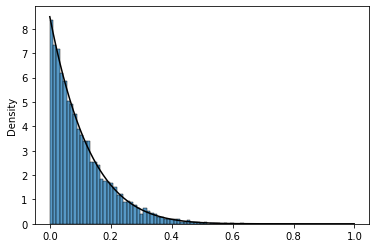

In [160]:
ax = sns.histplot(x = rsqs, stat = "density")
xs = np.arange(0, 1, 0.001)
ax.plot(xs, stats.beta.pdf(xs, (K-1)/2, (n-K)/2), color = "black")

If the null-hypothesis is true, the simulated $R^2$s will look just like this!

### Applying it

The *p*-value of a positive test statistic $T$ is $P(T\geq t)$, where $t$ is the observed value. In our case, we found that 

In [106]:
fit.rsquared

0.08650663499174571

How unlikely is this this $R^2$ if the null-hypothesis is true?

Using [`scipy.stats.beta`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html), we can finds the probability that $R^2\geq0.0865$.

In [141]:
n = titanic.shape[0]
K = 4
# sf is the "survival function" P(T > t).
stats.beta.sf(fit.rsquared, (K - 1)/2, (n - K)/2)

1.1102230246251565e-16

This *p*-value turns out to be extremely inaccurate. The value I got using `R` is `7.226502e-43`, many orders of magnitude smaller.

**Conclusion:** Reject the null-hypothesis that $\beta_i = 0$ for all $i > 1$, in other words, the categorical variable `Class` matters!

### The $F$-test
An $F$-test is a generic term for a testing problem where the distribution of the test statistic is [$F$-distributed](https://en.wikipedia.org/wiki/F-distribution). We care about the $F$-distributed statistic above because it equals $0$ if and only if $R^2$ is equal to 0. The distribution of $R^2$ is not commonly used, for reason I do not fathom. Instead, everyone uses the $F$-test. You can find its output in e.g. `statsmodels`.

We can write down the test statistic for the $F$ distribution in several ways. This one is especially convenient for us:
$$
\frac{n-K}{K-1}\frac{R^{2}}{1-R^{2}} \sim F(K-1, n - K)
$$

The $F$ tests takes two parameters, $d_1$ and $d_2$, called the degrees of freedom. In this case, $d_1 = K-1$ and $d_2 = n - K$. The parameter $d_1$ is sometimes called the numerator degree of freedom, $d_2$ the denominator degree of freedom.

**Note:**
I didn't misspell the names of $d_1$ and $d_2$. They are given these names since the $F$ statistic can be written in a different way, where $n-K$ is the denominator and $K-1$ the numerator. See e.g. the wikipedia page about the $F$-distribution. 



Using the $F$-test, we can test exactly the same null-hypothesis as we did with the Beta distribution. Python manages to calculate the *p*-value accurately in this case, namely:

In [136]:
fit.f_pvalue

7.55923138291284e-43

We will continue to discuss the $F$-test - and its connection to $R^2$ - in the nest lecture.

## Summary
1. We can test if at least one of the coefficients $\beta \neq 0$ using the $F$-test or the Beta distribution.
2. Using the $F$-test is equivalent to testing if the $R^2$ is greater than $0$.